In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from lime.lime_text import LimeTextExplainer

# import custom functions
from utils import *

In [2]:
CODE_DIR = os.getcwd()
WORK_DIR = os.path.dirname(os.path.dirname(CODE_DIR))
DATA_DIR = os.path.join(WORK_DIR, 'data', 'beer_review')
DATA_BeerAdvocate = os.path.join(DATA_DIR, 'BeerAdvocate')
MAX_ROW = 1000

In [3]:
ratings = open_big_txt(DATA_BeerAdvocate, 'ratings', MAX_ROW)

In [4]:
# show the column 'rating' and 'text'
ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.0,3.5,3.5,4.0,3.5,3.67,Pours pale copper with a thin head that quickl...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.0,3.5,3.5,4.0,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,helloloser12345.10867,4.0,3.5,4.0,4.0,4.5,3.98,Serving,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,cypressbob.3708,4.0,4.0,4.0,4.0,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",True


In [5]:
# set numerical data type from object to float
ratings['rating'] = ratings['rating'].astype(float)
ratings['review'] = ratings['review'].astype(bool)
# check the data type of each column
ratings['text'] = ratings['text'].astype(str)

## Quick EDA

In [6]:
ratings['rating'].describe()

count    1001.000000
mean        3.585155
std         0.549492
min         1.000000
25%         3.300000
50%         3.680000
75%         3.950000
max         5.000000
Name: rating, dtype: float64

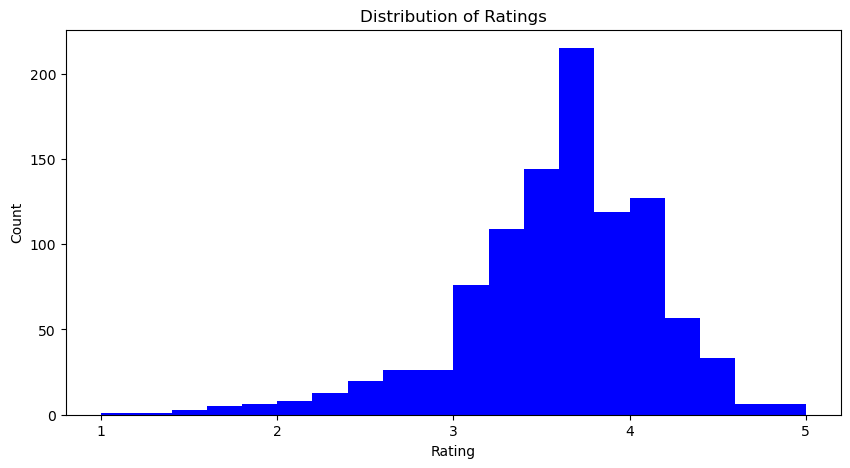

In [7]:
# study the distribution of rating
plt.figure(figsize=(10, 5))
plt.hist(ratings['rating'], bins=20, color = 'blue')
plt.xlabel('Rating')
plt.ylabel('Count')
# set x ticks
plt.xticks(np.arange(1, 6, 1))
plt.title('Distribution of Ratings')
plt.show()

In [36]:
# add a discrete rating column
# 1: 1-3, 2: 3-4, 3: 4-5
ratings['rating_discrete'] = ratings['rating'].apply(lambda x: 1 if x <= 3 else (2 if x <= 4 else 3))

In [37]:
# filter the ratings
ratings_filtered = ratings.copy()
print("rating before filtering: ", len(ratings_filtered))
ratings_filtered = ratings_filtered[ratings_filtered['text'] != 'nan']
ratings_filtered = ratings_filtered[ratings_filtered['rating'].notna()]
print("rating after filtering: ", len(ratings_filtered))

rating before filtering:  1001
rating after filtering:  564


## Pretrained Model

In [17]:
# get the pretrained model from huggingface's transformers library
#MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
MODEL = f"juliensimon/reviews-sentiment-analysis"
#MODEL = f"lxyuan/distilbert-base-multilingual-cased-sentiments-student"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [18]:
# run sentiment analysis over all ratings['text']
def polarity_scores(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'o1' : scores[0],
        'o2' : scores[1],
        #'o3' : scores[2]
    }
    return scores_dict

In [19]:
res = {}
for i, row in tqdm(ratings_filtered.iterrows(), total=len(ratings_filtered)):
    try:
        text = row['text']
        myid = i
        result = polarity_scores(text)
        #result = extract_sentiment_words_attention(text)
        res[myid] = result
    except RuntimeError:
        print(f'Broke for id {myid}') # model can't handle some texts (i.e. too long)

100%|██████████| 564/564 [01:37<00:00,  5.81it/s]


In [25]:
results_df = pd.DataFrame(res).T
# add column 'class', if o1 > o2, then class = 0, else class = 1
results_df['class'] = results_df['o1'].apply(lambda x: 0 if x > 0.5 else 1)
results_df.head()

,o1,o2,class
0,0.987889,0.012111,0
1,0.525460,0.474540,0
2,0.776491,0.223509,0
3,0.514384,0.485616,0
4,0.199073,0.800927,1


In [38]:
# merge the results with the original ratings dataframe
ratings_merged = ratings_filtered.merge(results_df, left_index=True, right_index=True)
ratings_merged.head(10)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,text,review,rating_discrete,o1,o2,class
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,...,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True,1,0.987889,0.012111,0
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.0,...,3.5,4.0,3.5,3.67,Pours pale copper with a thin head that quickl...,True,2,0.525460,0.474540,0
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.0,...,3.5,4.0,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True,2,0.776491,0.223509,0
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,helloloser12345.10867,4.0,...,4.0,4.0,4.5,3.98,Serving,True,2,0.514384,0.485616,0
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,cypressbob.3708,4.0,...,4.0,4.0,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",True,2,0.199073,0.800927,1
12,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1360753200,brewdude1982,brewdude1982.691169,4.25,...,3.25,3.75,3.75,3.91,This was a 12 oz bottle poured into a snifter....,True,2,0.780030,0.219970,0
13,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1357729200,AgentMunky,agentmunky.409755,4.0,...,3.5,3.5,3.75,3.64,Poured from a 12 ounce bottle into a pilsner g...,True,2,0.580841,0.419159,0
17,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1353150000,ferrari29,ferrari29.320392,3.0,...,2.5,2.5,2.5,2.77,Beer poured from bottle into a Nonic shaped pi...,True,1,0.922246,0.077754,0
19,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1342260000,OtherShoe2,othershoe2.233642,4.0,...,4.0,3.5,4.0,3.68,Pours a rich brownish red with some chill haze...,True,2,0.229101,0.770899,1
21,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1335607200,brentk56,brentk56.6284,4.5,...,3.5,2.5,2.5,2.84,Appearance,True,1,0.624000,0.376000,0


c:\Users\asus\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


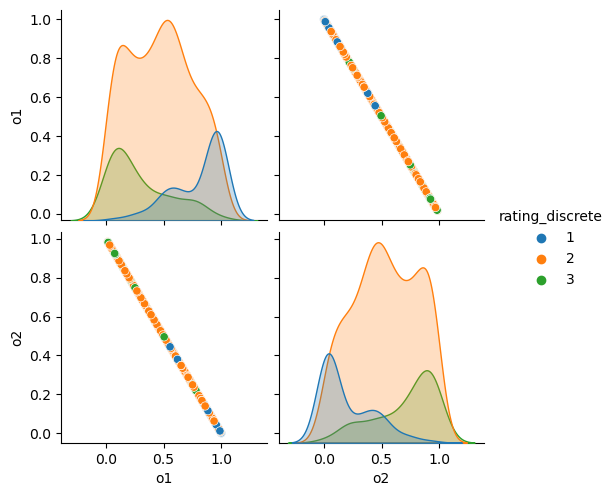

In [39]:
sns.pairplot(data = ratings_merged, 
             vars = ['o1', 'o2'],
             hue = 'rating_discrete',
             palette = 'tab10')
plt.show()

## Word cloud

In [43]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = set(stopwords.words('english'))
import string

def process(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    words = [word.lower() for word in words if word not in string.punctuation]
    
    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    
    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
ratings_merged['text_processed'] = ratings_merged['text'].apply(process)

In [45]:
ratings_merged.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,taste,overall,rating,text,review,rating_discrete,o1,o2,class,text_processed
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,...,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True,1,0.987889,0.012111,0,"[bottle, pours, piss, yellow, color, fizzy, wh..."
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.0,...,4.0,3.5,3.67,Pours pale copper with a thin head that quickl...,True,2,0.525460,0.474540,0,"[pours, pale, copper, thin, head, quickly, goe..."
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.0,...,4.0,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True,2,0.776491,0.223509,0,"[500ml, bottle, bought, vintage, antrim, ..., ..."
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,helloloser12345.10867,4.0,...,4.0,4.5,3.98,Serving,True,2,0.514384,0.485616,0,[serving]
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,cypressbob.3708,4.0,...,4.0,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",True,2,0.199073,0.800927,1,"[500ml, bottlepours, light, slightly, hazy, go..."


In [55]:
# show data type
ratings_merged.dtypes

beer_name           object
beer_id             object
brewery_name        object
brewery_id          object
style               object
abv                 object
date                object
user_name           object
user_id             object
appearance          object
aroma               object
palate              object
taste               object
overall             object
rating             float64
text                object
review                bool
rating_discrete      int64
o1                 float32
o2                 float32
class                int64
text_processed      object
dtype: object

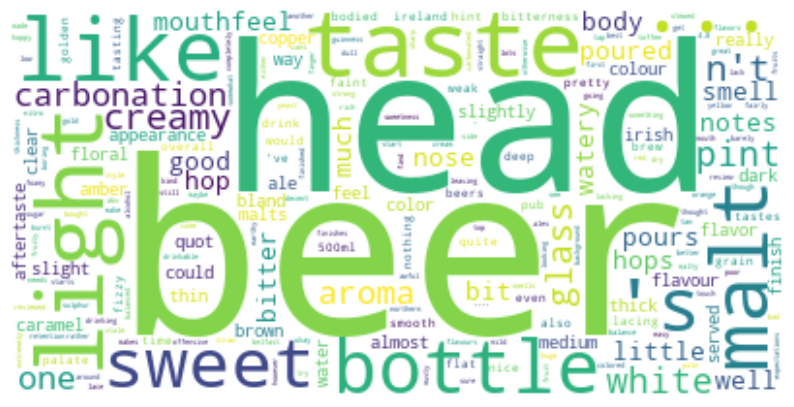

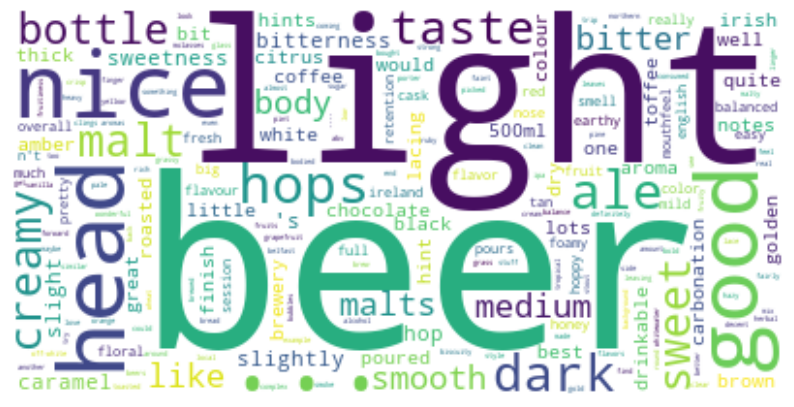

In [53]:
# made a word cloud for each class
from wordcloud import WordCloud
from collections import Counter

def wordcloud_draw(df):
    words = []
    for line in df['text_processed']:
        words.extend(line)
    
    # Create a word frequency dictionary
    wordfreq = Counter(words)
    # draw a Word Cloud with word frequencies
    wordcloud = WordCloud(background_color='white', 
                          max_words=2000,
                          stopwords=stopwords
                          ).generate_from_frequencies(wordfreq)
    plt.figure(figsize=(10,9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
wordcloud_draw(ratings_merged[ratings_merged['rating_discrete'] == 1])
wordcloud_draw(ratings_merged[ratings_merged['rating_discrete'] == 3])